In [1]:
import tensorflow
import keras

Using TensorFlow backend.


In [2]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

ModuleNotFoundError: No module named 'xgboost'

In [3]:
import subprocess
subprocess.check_call(["python", '-m', 'pip', 'install', 'xgboost']) # install pkg

0

In [4]:
from xgboost import XGBRegressor

In [18]:
def get_data():
    #get train data
    train_data_path ='AGFtrain.csv'
    train = pd.read_csv(train_data_path)
    
    #get test data
    test_data_path ='AGFtest.csv'
    test = pd.read_csv(test_data_path)
    
    return train , test

def get_combined_data():
  #reading train data
  train , test = get_data()

  target = train.ST
  train.drop(['ST'],axis = 1 , inplace = True)

  combined = train.append(test)
  combined.reset_index(inplace=True)
  combined.drop(['index'], inplace=True, axis=1)
  return combined, target

#Load train and test data into pandas DataFrames
train_data, test_data = get_data()

#Combine train and test data to process them together
combined, target = get_combined_data()

In [19]:
combined.describe()

,RH,Rain,Rs,SM,ST,Ta,U2,VPD
count,100.000000,100.000000,100.000000,100.000000,0.0,100.000000,100.000000,100.000000
mean,77.643333,5.595300,331.086250,0.122987,NaN,20.055083,0.847000,0.507224
std,11.005102,18.958822,123.060519,0.034828,NaN,3.614283,0.572021,0.228181
min,51.416667,0.000000,72.708333,0.064075,NaN,14.254167,0.000000,0.066198
25%,70.755208,0.000000,231.572917,0.090007,NaN,17.055208,0.425000,0.377599
50%,78.635417,0.000000,329.395833,0.117090,NaN,19.819792,0.883333,0.453489
75%,85.614583,0.050000,394.833333,0.157575,NaN,22.805729,1.275000,0.655991
max,97.145833,134.640000,633.166667,0.192608,NaN,26.795833,2.500000,1.094926


In [20]:

def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [24]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

In [23]:
print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 8
Number of nun-numerical columns with no nan values : 0


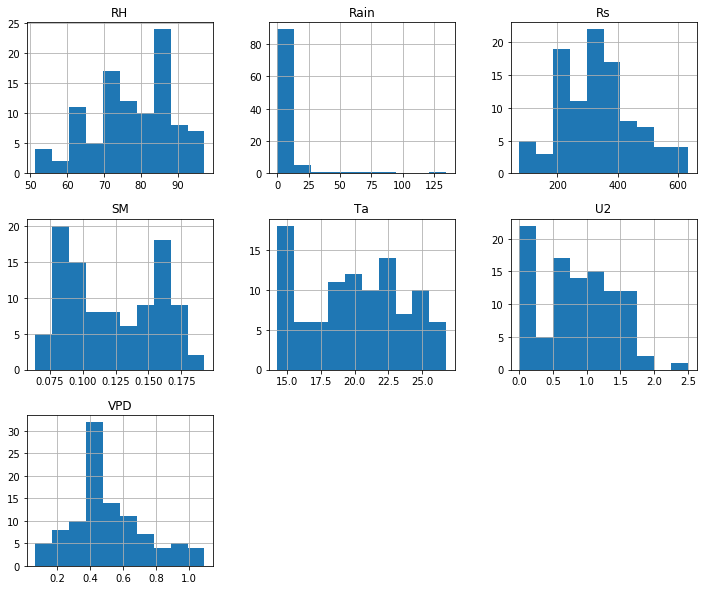

In [25]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

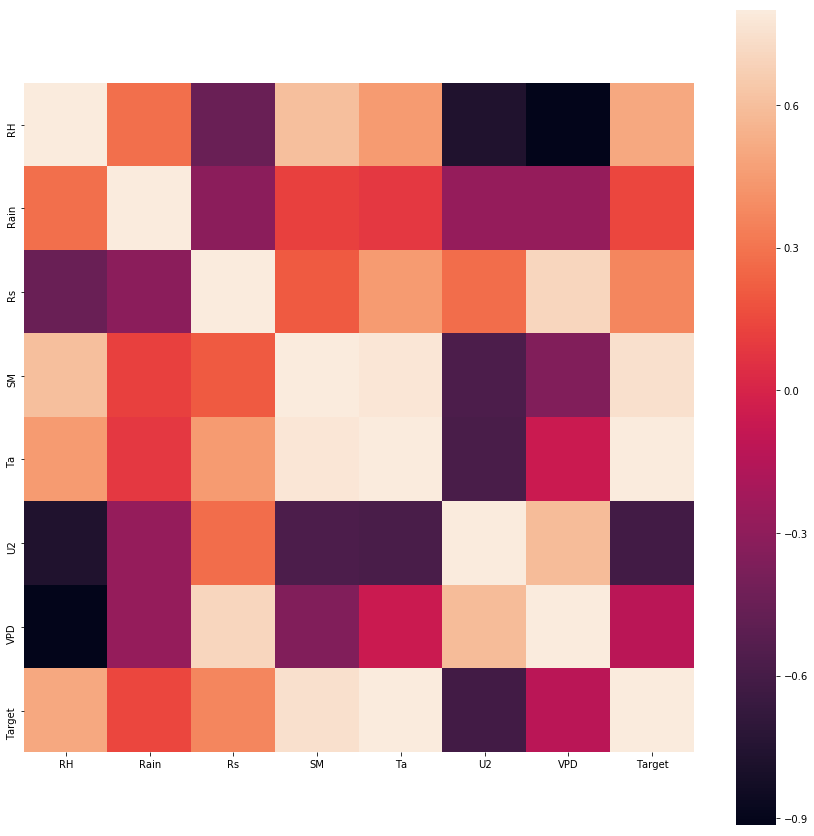

In [26]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [27]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 7 columns before encoding categorical features
There are 7 columns after encoding categorical features


In [34]:
def split_combined():
    global combined
    train = combined[:78]
    test = combined[78:]

    return train , test 
  
train, test = split_combined()

In [35]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               1024      
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 165,889
Trainable params: 165,889
Non-trainable params: 0
_________________________________________________________________


In [36]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [37]:
NN_model.fit(train, target, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Train on 62 samples, validate on 16 samples
Epoch 1/500
62/62 [==============================] - 3s 47ms/step - loss: 17.9753 - mean_absolute_error: 17.9753 - val_loss: 9.9130 - val_mean_absolute_error: 9.9130

Epoch 00001: val_loss improved from inf to 9.91299, saving model to Weights-001--9.91299.hdf5
Epoch 2/500
62/62 [==============================] - 0s 177us/step - loss: 11.2968 - mean_absolute_error: 11.2968 - val_loss: 3.6702 - val_mean_absolute_error: 3.6702

Epoch 00002: val_loss improved from 9.91299 to 3.67016, saving model to Weights-002--3.67016.hdf5
Epoch 3/500
62/62 [==============================] - 0s 177us/step - loss: 3.9531 - mean_absolute_error: 3.9531 - val_loss: 15.7945 - val_mean_absolute_error: 15.7945

Epoch 00003: val_loss did not improve from 3.67016
Epoch 4/500
62/62 [==============================] - 0s 209us/step - loss: 7.5002 - mean_absolute_error: 7.5002 - val_loss: 12.7268 - val_mean_absolute_error: 12.

Epoch 36/500
62/62 [==============================] - 0s 370us/step - loss: 0.9586 - mean_absolute_error: 0.9586 - val_loss: 2.4558 - val_mean_absolute_error: 2.4558

Epoch 00036: val_loss did not improve from 2.25000
Epoch 37/500
62/62 [==============================] - 0s 418us/step - loss: 0.9395 - mean_absolute_error: 0.9395 - val_loss: 2.2077 - val_mean_absolute_error: 2.2077

Epoch 00037: val_loss improved from 2.25000 to 2.20765, saving model to Weights-037--2.20765.hdf5
Epoch 38/500
62/62 [==============================] - 0s 402us/step - loss: 0.9125 - mean_absolute_error: 0.9125 - val_loss: 2.3071 - val_mean_absolute_error: 2.3071

Epoch 00038: val_loss did not improve from 2.20765
Epoch 39/500
62/62 [==============================] - 0s 579us/step - loss: 0.9111 - mean_absolute_error: 0.9111 - val_loss: 2.2548 - val_mean_absolute_error: 2.2548

Epoch 00039: val_loss did not improve from 2.20765
Epoch 40/500
62/62 [==============================] - 0s 467us/step - loss: 0.953


Epoch 00072: val_loss did not improve from 2.06981
Epoch 73/500
62/62 [==============================] - 0s 257us/step - loss: 0.8344 - mean_absolute_error: 0.8344 - val_loss: 2.1763 - val_mean_absolute_error: 2.1763

Epoch 00073: val_loss did not improve from 2.06981
Epoch 74/500
62/62 [==============================] - 0s 241us/step - loss: 0.9335 - mean_absolute_error: 0.9335 - val_loss: 2.6045 - val_mean_absolute_error: 2.6045

Epoch 00074: val_loss did not improve from 2.06981
Epoch 75/500
62/62 [==============================] - 0s 273us/step - loss: 0.9282 - mean_absolute_error: 0.9282 - val_loss: 2.2117 - val_mean_absolute_error: 2.2117

Epoch 00075: val_loss did not improve from 2.06981
Epoch 76/500
62/62 [==============================] - 0s 290us/step - loss: 0.9030 - mean_absolute_error: 0.9030 - val_loss: 2.4203 - val_mean_absolute_error: 2.4203

Epoch 00076: val_loss did not improve from 2.06981
Epoch 77/500
62/62 [==============================] - 0s 225us/step - loss: 

62/62 [==============================] - 0s 306us/step - loss: 0.7409 - mean_absolute_error: 0.7409 - val_loss: 2.0985 - val_mean_absolute_error: 2.0985

Epoch 00110: val_loss did not improve from 2.06981
Epoch 111/500
62/62 [==============================] - 0s 209us/step - loss: 0.7044 - mean_absolute_error: 0.7044 - val_loss: 2.3143 - val_mean_absolute_error: 2.3143

Epoch 00111: val_loss did not improve from 2.06981
Epoch 112/500
62/62 [==============================] - 0s 177us/step - loss: 0.7577 - mean_absolute_error: 0.7577 - val_loss: 2.0745 - val_mean_absolute_error: 2.0745

Epoch 00112: val_loss did not improve from 2.06981
Epoch 113/500
62/62 [==============================] - 0s 257us/step - loss: 0.7598 - mean_absolute_error: 0.7598 - val_loss: 2.6106 - val_mean_absolute_error: 2.6106

Epoch 00113: val_loss did not improve from 2.06981
Epoch 114/500
62/62 [==============================] - 0s 241us/step - loss: 0.9526 - mean_absolute_error: 0.9526 - val_loss: 2.0905 - val

62/62 [==============================] - 0s 225us/step - loss: 0.7060 - mean_absolute_error: 0.7060 - val_loss: 2.6831 - val_mean_absolute_error: 2.6831

Epoch 00147: val_loss did not improve from 2.05452
Epoch 148/500
62/62 [==============================] - 0s 290us/step - loss: 0.8292 - mean_absolute_error: 0.8292 - val_loss: 2.1351 - val_mean_absolute_error: 2.1351

Epoch 00148: val_loss did not improve from 2.05452
Epoch 149/500
62/62 [==============================] - 0s 290us/step - loss: 0.6071 - mean_absolute_error: 0.6071 - val_loss: 2.2506 - val_mean_absolute_error: 2.2506

Epoch 00149: val_loss did not improve from 2.05452
Epoch 150/500
62/62 [==============================] - 0s 273us/step - loss: 0.5766 - mean_absolute_error: 0.5766 - val_loss: 2.0982 - val_mean_absolute_error: 2.0982

Epoch 00150: val_loss did not improve from 2.05452
Epoch 151/500
62/62 [==============================] - 0s 273us/step - loss: 0.5720 - mean_absolute_error: 0.5720 - val_loss: 2.4402 - val

62/62 [==============================] - 0s 241us/step - loss: 0.7121 - mean_absolute_error: 0.7121 - val_loss: 2.0091 - val_mean_absolute_error: 2.0091

Epoch 00184: val_loss did not improve from 1.99777
Epoch 185/500
62/62 [==============================] - 0s 257us/step - loss: 0.6722 - mean_absolute_error: 0.6722 - val_loss: 2.6589 - val_mean_absolute_error: 2.6589

Epoch 00185: val_loss did not improve from 1.99777
Epoch 186/500
62/62 [==============================] - 0s 273us/step - loss: 1.0946 - mean_absolute_error: 1.0946 - val_loss: 2.0492 - val_mean_absolute_error: 2.0492

Epoch 00186: val_loss did not improve from 1.99777
Epoch 187/500
62/62 [==============================] - 0s 209us/step - loss: 0.7751 - mean_absolute_error: 0.7751 - val_loss: 2.2968 - val_mean_absolute_error: 2.2968

Epoch 00187: val_loss did not improve from 1.99777
Epoch 188/500
62/62 [==============================] - 0s 483us/step - loss: 0.5359 - mean_absolute_error: 0.5359 - val_loss: 2.4647 - val

62/62 [==============================] - 0s 177us/step - loss: 0.7272 - mean_absolute_error: 0.7272 - val_loss: 2.1147 - val_mean_absolute_error: 2.1147

Epoch 00221: val_loss did not improve from 1.99498
Epoch 222/500
62/62 [==============================] - 0s 241us/step - loss: 0.6812 - mean_absolute_error: 0.6812 - val_loss: 2.4188 - val_mean_absolute_error: 2.4188

Epoch 00222: val_loss did not improve from 1.99498
Epoch 223/500
62/62 [==============================] - 0s 225us/step - loss: 0.7663 - mean_absolute_error: 0.7663 - val_loss: 2.3677 - val_mean_absolute_error: 2.3677

Epoch 00223: val_loss did not improve from 1.99498
Epoch 224/500
62/62 [==============================] - 0s 209us/step - loss: 0.5323 - mean_absolute_error: 0.5323 - val_loss: 2.0723 - val_mean_absolute_error: 2.0723

Epoch 00224: val_loss did not improve from 1.99498
Epoch 225/500
62/62 [==============================] - 0s 209us/step - loss: 0.6809 - mean_absolute_error: 0.6809 - val_loss: 2.3910 - val


Epoch 00257: val_loss did not improve from 1.88617
Epoch 258/500
62/62 [==============================] - 0s 579us/step - loss: 0.4077 - mean_absolute_error: 0.4077 - val_loss: 2.0264 - val_mean_absolute_error: 2.0264

Epoch 00258: val_loss did not improve from 1.88617
Epoch 259/500
62/62 [==============================] - 0s 354us/step - loss: 0.4384 - mean_absolute_error: 0.4384 - val_loss: 2.0451 - val_mean_absolute_error: 2.0451

Epoch 00259: val_loss did not improve from 1.88617
Epoch 260/500
62/62 [==============================] - 0s 306us/step - loss: 0.5556 - mean_absolute_error: 0.5556 - val_loss: 1.8932 - val_mean_absolute_error: 1.8932

Epoch 00260: val_loss did not improve from 1.88617
Epoch 261/500
62/62 [==============================] - 0s 306us/step - loss: 0.4956 - mean_absolute_error: 0.4956 - val_loss: 2.0743 - val_mean_absolute_error: 2.0743

Epoch 00261: val_loss did not improve from 1.88617
Epoch 262/500
62/62 [==============================] - 0s 314us/step - l


Epoch 00294: val_loss did not improve from 1.78606
Epoch 295/500
62/62 [==============================] - 0s 547us/step - loss: 0.3703 - mean_absolute_error: 0.3703 - val_loss: 1.9326 - val_mean_absolute_error: 1.9326

Epoch 00295: val_loss did not improve from 1.78606
Epoch 296/500
62/62 [==============================] - 0s 257us/step - loss: 0.3662 - mean_absolute_error: 0.3662 - val_loss: 1.8376 - val_mean_absolute_error: 1.8376

Epoch 00296: val_loss did not improve from 1.78606
Epoch 297/500
62/62 [==============================] - 0s 306us/step - loss: 0.5092 - mean_absolute_error: 0.5092 - val_loss: 1.8385 - val_mean_absolute_error: 1.8385

Epoch 00297: val_loss did not improve from 1.78606
Epoch 298/500
62/62 [==============================] - 0s 290us/step - loss: 0.5251 - mean_absolute_error: 0.5251 - val_loss: 1.8947 - val_mean_absolute_error: 1.8947

Epoch 00298: val_loss did not improve from 1.78606
Epoch 299/500
62/62 [==============================] - 0s 290us/step - l

62/62 [==============================] - 0s 563us/step - loss: 0.5663 - mean_absolute_error: 0.5663 - val_loss: 2.2343 - val_mean_absolute_error: 2.2343

Epoch 00332: val_loss did not improve from 1.78606
Epoch 333/500
62/62 [==============================] - 0s 499us/step - loss: 0.5220 - mean_absolute_error: 0.5220 - val_loss: 1.8134 - val_mean_absolute_error: 1.8134

Epoch 00333: val_loss did not improve from 1.78606
Epoch 334/500
62/62 [==============================] - 0s 434us/step - loss: 0.4109 - mean_absolute_error: 0.4109 - val_loss: 1.9590 - val_mean_absolute_error: 1.9590

Epoch 00334: val_loss did not improve from 1.78606
Epoch 335/500
62/62 [==============================] - 0s 418us/step - loss: 0.3876 - mean_absolute_error: 0.3876 - val_loss: 1.8939 - val_mean_absolute_error: 1.8939

Epoch 00335: val_loss did not improve from 1.78606
Epoch 336/500
62/62 [==============================] - 0s 370us/step - loss: 0.3822 - mean_absolute_error: 0.3822 - val_loss: 2.2911 - val

62/62 [==============================] - 0s 257us/step - loss: 0.3365 - mean_absolute_error: 0.3365 - val_loss: 2.0022 - val_mean_absolute_error: 2.0022

Epoch 00369: val_loss did not improve from 1.78606
Epoch 370/500
62/62 [==============================] - 0s 354us/step - loss: 0.3758 - mean_absolute_error: 0.3758 - val_loss: 1.9743 - val_mean_absolute_error: 1.9743

Epoch 00370: val_loss did not improve from 1.78606
Epoch 371/500
62/62 [==============================] - 0s 274us/step - loss: 0.3366 - mean_absolute_error: 0.3366 - val_loss: 2.0312 - val_mean_absolute_error: 2.0312

Epoch 00371: val_loss did not improve from 1.78606
Epoch 372/500
62/62 [==============================] - 0s 434us/step - loss: 0.3503 - mean_absolute_error: 0.3503 - val_loss: 1.8901 - val_mean_absolute_error: 1.8901

Epoch 00372: val_loss did not improve from 1.78606
Epoch 373/500
62/62 [==============================] - 0s 515us/step - loss: 0.3253 - mean_absolute_error: 0.3253 - val_loss: 1.9737 - val


Epoch 00405: val_loss did not improve from 1.74898
Epoch 406/500
62/62 [==============================] - 0s 306us/step - loss: 0.6338 - mean_absolute_error: 0.6338 - val_loss: 2.2627 - val_mean_absolute_error: 2.2627

Epoch 00406: val_loss did not improve from 1.74898
Epoch 407/500
62/62 [==============================] - 0s 322us/step - loss: 0.5963 - mean_absolute_error: 0.5963 - val_loss: 1.8658 - val_mean_absolute_error: 1.8658

Epoch 00407: val_loss did not improve from 1.74898
Epoch 408/500
62/62 [==============================] - 0s 306us/step - loss: 0.6452 - mean_absolute_error: 0.6452 - val_loss: 2.1038 - val_mean_absolute_error: 2.1038

Epoch 00408: val_loss did not improve from 1.74898
Epoch 409/500
62/62 [==============================] - 0s 354us/step - loss: 0.5847 - mean_absolute_error: 0.5847 - val_loss: 2.0129 - val_mean_absolute_error: 2.0129

Epoch 00409: val_loss did not improve from 1.74898
Epoch 410/500
62/62 [==============================] - 0s 289us/step - l


Epoch 00442: val_loss did not improve from 1.69319
Epoch 443/500
62/62 [==============================] - 0s 354us/step - loss: 0.4329 - mean_absolute_error: 0.4329 - val_loss: 1.9570 - val_mean_absolute_error: 1.9570

Epoch 00443: val_loss did not improve from 1.69319
Epoch 444/500
62/62 [==============================] - 0s 322us/step - loss: 0.3380 - mean_absolute_error: 0.3380 - val_loss: 1.7270 - val_mean_absolute_error: 1.7270

Epoch 00444: val_loss did not improve from 1.69319
Epoch 445/500
62/62 [==============================] - 0s 322us/step - loss: 0.3484 - mean_absolute_error: 0.3484 - val_loss: 1.9757 - val_mean_absolute_error: 1.9757

Epoch 00445: val_loss did not improve from 1.69319
Epoch 446/500
62/62 [==============================] - 0s 354us/step - loss: 0.4360 - mean_absolute_error: 0.4360 - val_loss: 1.6778 - val_mean_absolute_error: 1.6778

Epoch 00446: val_loss improved from 1.69319 to 1.67781, saving model to Weights-446--1.67781.hdf5
Epoch 447/500
62/62 [====

62/62 [==============================] - 0s 370us/step - loss: 0.4324 - mean_absolute_error: 0.4324 - val_loss: 1.7882 - val_mean_absolute_error: 1.7882

Epoch 00479: val_loss did not improve from 1.64868
Epoch 480/500
62/62 [==============================] - 0s 273us/step - loss: 0.3148 - mean_absolute_error: 0.3148 - val_loss: 1.6243 - val_mean_absolute_error: 1.6243

Epoch 00480: val_loss improved from 1.64868 to 1.62429, saving model to Weights-480--1.62429.hdf5
Epoch 481/500
62/62 [==============================] - 0s 306us/step - loss: 0.4426 - mean_absolute_error: 0.4426 - val_loss: 1.7356 - val_mean_absolute_error: 1.7356

Epoch 00481: val_loss did not improve from 1.62429
Epoch 482/500
62/62 [==============================] - 0s 370us/step - loss: 0.3009 - mean_absolute_error: 0.3009 - val_loss: 1.7595 - val_mean_absolute_error: 1.7595

Epoch 00482: val_loss did not improve from 1.62429
Epoch 483/500
62/62 [==============================] - 0s 306us/step - loss: 0.2959 - mean_

In [41]:
wights_file = 'Weights-480--1.62429.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [71]:
NN_model.fit(train, target, batch_size = 10, epochs = 100)

Epoch 1/100
78/78 [==============================] - 2s 26ms/step - loss: 3.9085 - mean_absolute_error: 3.9085
Epoch 2/100
78/78 [==============================] - 0s 575us/step - loss: 2.2215 - mean_absolute_error: 2.2215
Epoch 3/100
78/78 [==============================] - 0s 754us/step - loss: 1.3171 - mean_absolute_error: 1.3171
Epoch 4/100
78/78 [==============================] - 0s 1ms/step - loss: 0.7821 - mean_absolute_error: 0.7821
Epoch 5/100
78/78 [==============================] - 0s 588us/step - loss: 0.8112 - mean_absolute_error: 0.8112
Epoch 6/100
78/78 [==============================] - 0s 780us/step - loss: 0.8032 - mean_absolute_error: 0.8032
Epoch 7/100
78/78 [==============================] - 0s 511us/step - loss: 0.5718 - mean_absolute_error: 0.5718
Epoch 8/100
78/78 [==============================] - 0s 780us/step - loss: 0.5279 - mean_absolute_error: 0.5279
Epoch 9/100
78/78 [==============================] - 0s 639us/step - loss: 0.6249 - mean_absolute_error: 0.

78/78 [==============================] - 0s 626us/step - loss: 0.7534 - mean_absolute_error: 0.7534
Epoch 74/100
78/78 [==============================] - 0s 690us/step - loss: 0.9845 - mean_absolute_error: 0.9845
Epoch 75/100
78/78 [==============================] - 0s 831us/step - loss: 0.9987 - mean_absolute_error: 0.9987
Epoch 76/100
78/78 [==============================] - 0s 690us/step - loss: 0.8215 - mean_absolute_error: 0.8215
Epoch 77/100
78/78 [==============================] - 0s 588us/step - loss: 0.7492 - mean_absolute_error: 0.7492
Epoch 78/100
78/78 [==============================] - 0s 678us/step - loss: 0.6562 - mean_absolute_error: 0.6562
Epoch 79/100
78/78 [==============================] - 0s 639us/step - loss: 0.5244 - mean_absolute_error: 0.5244
Epoch 80/100
78/78 [==============================] - 0s 588us/step - loss: 0.5796 - mean_absolute_error: 0.5796
Epoch 81/100
78/78 [==============================] - 0s 742us/step - loss: 0.4871 - mean_absolute_error: 0.4

In [68]:
train_X, val_X, train_y, val_y = train_test_split(train, target, test_size = 0.1, random_state = 14)

In [73]:
y_pred = model.predict(test)

In [74]:
print(y_pred)

[22.3277068  22.65866398 25.582159   25.62586681 25.62586681 25.36446494
 25.51094528 22.2516982  21.89414918 21.94935053 25.31739489 23.72238727
 25.33184036 25.50114398 25.58121002 22.77065407 22.77065407 25.4746663
 25.55560207 25.13970829 22.68853424 21.65503997]


In [ ]:
def split_combined():
    global combined
    train = combined[:78]
    test = combined[78:]

    return train , test 
  
train, test = split_combined()

In [81]:
model = RandomForestRegressor()
model.fit(train_X,train_y)

# Get the mean absolute error on the validation data
predicted_prices = model.predict(val_X)
MAE = mean_absolute_error(val_y , predicted_prices)
print('Random forest validation MAE = ', MAE)

Random forest validation MAE =  0.25336789800000137


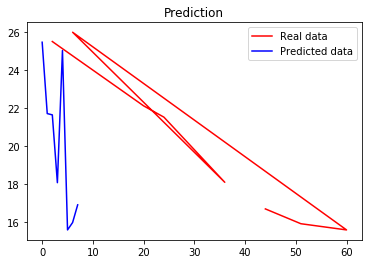

In [78]:
plt.plot(val_y, color = 'red', label = 'Real data')
plt.plot(predicted_prices, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

In [79]:
print(predicted_prices)

[25.45315824 21.70385766 21.63592459 18.07259659 25.01841854 15.5902777
 15.97854549 16.90777238]


In [86]:
XGBModel = XGBRegressor()
XGBModel.fit(train_X,train_y , verbose=False)

# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost validation MAE = ',MAE)

XGBoost validation MAE =  0.22959884728546154


In [85]:
from sklearn.svm import SVR

In [50]:
model = SVR()
model.fit(train_X,train_y)

# Get the mean absolute error on the validation data
predicted_prices = model.predict(val_X)
MAE = mean_absolute_error(val_y , predicted_prices)
print('Support Vector Regressor = ', MAE)

Random forest validation MAE =  2.4897279375034906


In [51]:
./nbconvert.py --format=pdf Day 1 regression results of Soil Temperature modelling.ipynb

SyntaxError: invalid syntax (<ipython-input-51-07b50b0a7720>, line 1)

In [52]:
jupyter nbconvert Decorators.ipynb --to pdf

SyntaxError: invalid syntax (<ipython-input-52-d6117faed17b>, line 1)

In [53]:
import subprocess
subprocess.check_call(["python", '-m', 'pip', 'install', 'nbconvert']) # install pkg

0

In [55]:
nbconvert Day 1 regression results of Soil Temperature modelling.ipynb

SyntaxError: invalid syntax (<ipython-input-55-95e34c0ab9af>, line 1)

In [75]:
import numpy as np
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# Importing the dataset
dataset = np.genfromtxt("AGFDataset.txt", delimiter='')
X = dataset[:, :-1]
y = dataset[:, -1]

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Initialising the ANN
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(32, activation = 'relu', input_dim = 6))

# Adding the second hidden layer
model.add(Dense(units = 32, activation = 'relu'))

# Adding the third hidden layer
model.add(Dense(units = 32, activation = 'relu'))

# Adding the output layer

model.add(Dense(units = 1))

#model.add(Dense(1))
# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the ANN to the Training set
model.fit(X_train, y_train, batch_size = 10, epochs = 100)

y_pred = model.predict(X_test)

plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

ValueError: Error when checking input: expected dense_11_input to have shape (6,) but got array with shape (7,)

In [76]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Set random seed
np.random.seed(0)